# Date Selection
This notebook allows to plot average precipitation and temperature over the Lombardy region for a given month of the year.

## Import libraries

In [1]:
from sodapy import Socrata
import pandas as pd
import geopandas as gpd
import os
import zipfile
import requests
import json
import io
from scipy import stats
import numpy as np
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Set current working directory
cwd = os.getcwd()

# Import functions defined for DDUST project:
from functions import my_methods

# Key and app token for Socrata API
f = open('keys.json')
keys = json.load(f)

## Define time range
Select a month and a year:

In [17]:
month = 2
year = 2021
start_date_dt = datetime(year, month, 1).date()
print(start_date_dt)

2021-02-01


In [29]:
# Function to get the last day of the month
def last_day_month(test_date):            
    # getting next month
    # using replace to get to last day + offset
    # to reach next month
    nxt_mnth = test_date.replace(day=28) + timedelta(days=4)

    # subtracting the days from next month date to
    # get last date of current Month
    res = nxt_mnth - timedelta(days=nxt_mnth.day)

    return res

In [30]:
# Start and end days of the month
start_date = str(start_date_dt)
end_date = str(last_day_month(start_date_dt))[0:10]
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=1)
print('The time range is '+start_date + ' - ' + end_date)

The time range is 2021-02-01 - 2021-02-28


## Get ARPA meteorological sensors information

In [5]:
arpa_domain = "www.dati.lombardia.it"
m_st_descr = "nf78-nj6b"
client = Socrata(arpa_domain, app_token = keys['arpa_token'])
results = client.get_all(m_st_descr)
meteo_st_descr = pd.DataFrame(results)
meteo_st_descr["idsensore"] = meteo_st_descr["idsensore"].astype(int)

## Get ARPA meteorological sensors times series

In [6]:
# If current year use data from API
if int(year) == datetime.today().year:
    arpa_domain = "www.dati.lombardia.it"
    dati = "647i-nhxk" #change this depending on the dataset (check Open Data Lombardia datasets)
    client = Socrata(arpa_domain, app_token = keys['arpa_token']) #insert your arpa_token
    date_query = "data > {} and data < {}".format('"'+ start_date + '"','"'+ str(end_date_dt) + '"')
    results = client.get(dati, where=date_query, limit=5000000000000)
    meteo_data = pd.DataFrame(results)
    meteo_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data['data'] =  pd.to_datetime(meteo_data['data'], format='%Y/%m/%d %H:%M:%S')
    meteo_data = meteo_data.astype({"idsensore": int,"valore": float})
    
# If previous years download the corresponding year .csv file and filter the dates  
elif int(year) < datetime.today().year:
    filename = 'meteo_'+str(year)+'.zip'
    if not os.path.exists(os.path.join(filename)):
        csv_url = my_methods.meteo_sensor(str(year))
        r2 = requests.get(csv_url, allow_redirects=True)
        DL_zip = open(filename, 'wb').write(r2.content)
        print('Dowloaded zip file')
    
    print('Zip file exist')
    archive = zipfile.ZipFile(filename, 'r')
    data = archive.open(str(year)+'.csv') 
    meteo_data_df = pd.read_csv(data, dtype={"IdSensore": int,"Valore": float, "Stato": str, "idOperatore":str})
    meteo_data_df.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data_df['data'] =  pd.to_datetime(meteo_data_df['data'], format='%d/%m/%Y %H:%M:%S')

Zip file exist


For .csv data, the whole dataset is loaded in meteo_data_df dataframe. Changing the time period is possible to filter the data and

In [31]:
# Keep meteo_data_df in memory for .csv files only. It's possible to create a new meteo_data dataframe changing the time period
mask = (meteo_data_df.data >= start_date) & (meteo_data_df.data < str(end_date_dt))
meteo_data = meteo_data_df.loc[mask]

## Data processing

In [32]:
meteo_data = meteo_data.drop(columns=['stato', 'idoperatore'])
meteo_data = meteo_data[meteo_data.valore.astype(float) != -9999]

In [33]:
m_sensor_sel = ['Precipitazione','Temperatura']
meteo_table = pd.merge(meteo_data, meteo_st_descr, on = 'idsensore')

In [34]:
meteo_table['tipologia'].astype(str)
meteo_table = meteo_table[meteo_table['tipologia'].isin(m_sensor_sel)]

In [35]:
temp_st = meteo_table.loc[meteo_table['tipologia'] == 'Temperatura']
prec_st = meteo_table.loc[meteo_table['tipologia'] == 'Precipitazione']

In [36]:
prec_st

,idsensore,data,valore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
408241,5856,2021-02-01 00:00:00,0.0,Precipitazione,mm,595,Filago v.Don Milani,190,BG,1991-12-07T00:00:00.000,N,5053519,543342,9.556084255790864,45.63386450908066,"{'latitude': '45.63386450908066', 'longitude':...",5,5,NaN
408242,5856,2021-02-01 01:00:00,0.0,Precipitazione,mm,595,Filago v.Don Milani,190,BG,1991-12-07T00:00:00.000,N,5053519,543342,9.556084255790864,45.63386450908066,"{'latitude': '45.63386450908066', 'longitude':...",5,5,NaN
408243,5856,2021-02-01 02:00:00,0.0,Precipitazione,mm,595,Filago v.Don Milani,190,BG,1991-12-07T00:00:00.000,N,5053519,543342,9.556084255790864,45.63386450908066,"{'latitude': '45.63386450908066', 'longitude':...",5,5,NaN
408244,5856,2021-02-01 03:00:00,0.0,Precipitazione,mm,595,Filago v.Don Milani,190,BG,1991-12-07T00:00:00.000,N,5053519,543342,9.556084255790864,45.63386450908066,"{'latitude': '45.63386450908066', 'longitude':...",5,5,NaN
408245,5856,2021-02-01 04:00:00,0.0,Precipitazione,mm,595,Filago v.Don Milani,190,BG,1991-12-07T00:00:00.000,N,5053519,543342,9.556084255790864,45.63386450908066,"{'latitude': '45.63386450908066', 'longitude':...",5,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4263566,10585,2021-02-28 23:10:00,0.0,Precipitazione,mm,1274,Perledo P.zza della stazione,212,LC,2010-07-01T00:00:00.000,N,5095846,522171,9.286409208680807,46.01582830438376,"{'latitude': '46.01582830438376', 'longitude':...",10,10,NaN
4263567,10585,2021-02-28 23:20:00,0.0,Precipitazione,mm,1274,Perledo P.zza della stazione,212,LC,2010-07-01T00:00:00.000,N,5095846,522171,9.286409208680807,46.01582830438376,"{'latitude': '46.01582830438376', 'longitude':...",10,10,NaN
4263568,10585,2021-02-28 23:30:00,0.0,Precipitazione,mm,1274,Perledo P.zza della stazione,212,LC,2010-07-01T00:00:00.000,N,5095846,522171,9.286409208680807,46.01582830438376,"{'latitude': '46.01582830438376', 'longitude':...",10,10,NaN
4263569,10585,2021-02-28 23:40:00,0.0,Precipitazione,mm,1274,Perledo P.zza della stazione,212,LC,2010-07-01T00:00:00.000,N,5095846,522171,9.286409208680807,46.01582830438376,"{'latitude': '46.01582830438376', 'longitude':...",10,10,NaN


In [37]:
# Remove Outliers
# For precipitation values less than 100 mm/h
prec_st = prec_st[prec_st.valore < 100]

# For temperature using a Z-Score with high threshold
threshold = 4
temp_st['zscore'] = np.abs(stats.zscore(temp_st['valore'], nan_policy='propagate'))
temp_st = temp_st[temp_st.zscore < threshold]

Create month precipitation and temperature dataframes:

In [38]:
prec_st['data'] = pd.to_datetime(prec_st['data'], format='%Y-%m-%d hh:mm:ss')
temp_st['data'] = pd.to_datetime(temp_st['data'], format='%Y-%m-%d hh:mm:ss')

In [39]:
# Precipitation
prec_mean = prec_st.groupby(pd.Grouper(freq='D', key='data')).mean()
prec_mean = prec_mean.drop(columns=['idsensore'])
prec_mean['data'] = prec_mean.index

#Temperature
temp_mean = temp_st.groupby(pd.Grouper(freq='D', key='data')).mean()
temp_mean = temp_mean.drop(columns=['idsensore'])
temp_mean['data'] = temp_mean.index

## Plot mean temperature and precipitation for all ARPA sensor over Lombardy region

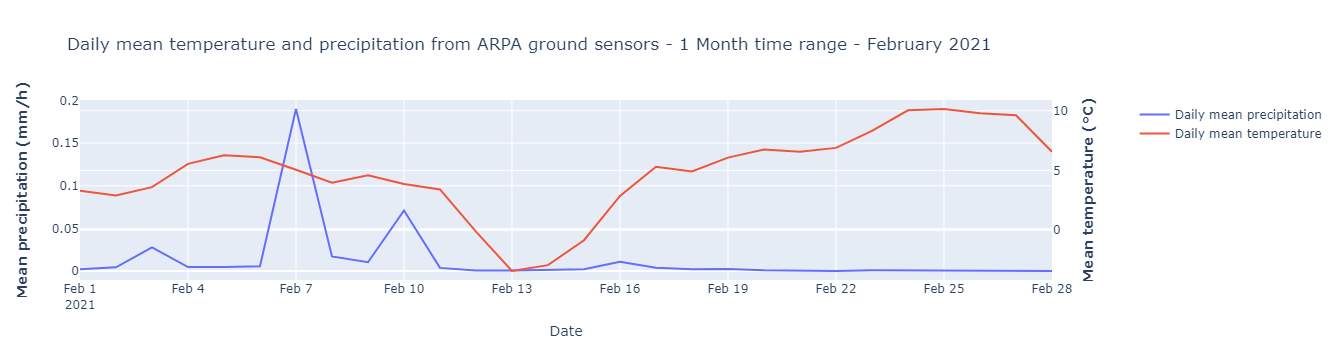

In [40]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=prec_mean.index, y=prec_mean.valore, name="Daily mean precipitation"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=temp_mean.index, y=temp_mean.valore, name="Daily mean temperature"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Daily mean temperature and precipitation from ARPA ground sensors - 1 Month time range - " +str(start_date_dt.strftime("%B %Y"))
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Mean precipitation (mm/h)</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Mean temperature (°C)</b>", secondary_y=True)

fig.show()

----

Could be used for longer time ranges. With 1 month is better to use graph maybe

In [ ]:
prec_mean['roll'] = prec_mean['valore'].rolling(7).mean()
temp_mean['roll'] = temp_mean['valore'].rolling(7).mean()

In [ ]:
prec_mean_min = prec_mean['roll'].min()
temp_mean_max = temp_mean['roll'].max()

In [ ]:
final_prec = prec_mean.loc[prec_mean['roll'] == prec_mean_min]
final_temp = temp_mean.loc[temp_mean['roll'] == temp_mean_max]

In [ ]:
print('Least raining period: ' + str(final_prec.index[0]-timedelta(days=6))[0:10], 'to '+ str(final_prec.index[0])[0:10])
print('Highest temperature period: ' + str(final_temp.index[0]-timedelta(days=6))[0:10], 'to '+ str(final_temp.index[0])[0:10])

In [ ]:
prec_mean

In [ ]:
temp_mean